In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

## Analysis

In [2]:
df_cluster = pd.read_csv('retailer_cluster.csv')
df_exposure = pd.read_csv('freq_exposition_achat_merged2.csv')
df_final_matched = pd.read_csv('final_matched.csv')

In [3]:
print(df_cluster.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354583 entries, 0 to 1354582
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Unnamed: 0          1354583 non-null  int64  
 1   customer_id         1354583 non-null  object 
 2   total_sales         1354583 non-null  float64
 3   total_quantity      1354583 non-null  float64
 4   num_brands          1354583 non-null  int64  
 5   num_transactions    1354583 non-null  int64  
 6   recency             1354583 non-null  int64  
 7   purchase_frequency  1354583 non-null  float64
 8   R_score             1354583 non-null  int64  
 9   F_score             1354583 non-null  int64  
 10  M_score             1354583 non-null  int64  
 11  RFM_Score           1354583 non-null  float64
 12  Cluster             1354583 non-null  object 
dtypes: float64(4), int64(7), object(2)
memory usage: 134.4+ MB
None


In [4]:
display(df_cluster.head(10))

,Unnamed: 0,customer_id,total_sales,total_quantity,num_brands,num_transactions,recency,purchase_frequency,R_score,F_score,M_score,RFM_Score,Cluster
0,0,re0007V8sqIHsZnbvC,0.00,0.0,1,2,153,0.011050,1,1,1,1.000000,Light
1,1,re000JYhnKbTkPqMB4,0.00,0.0,1,3,174,0.016575,1,2,1,1.333333,Light
2,2,re000fIO9QXTWYjOfn,284.52,8.0,2,23,9,0.127072,3,3,3,3.000000,Heavy
3,3,re000kbtVVzPwZcEr4,0.00,0.0,1,19,36,0.104972,3,3,1,2.333333,Medium
4,4,re000pHbVOysCXRHgt,394.94,5.0,1,17,22,0.093923,3,3,3,3.000000,Heavy
5,5,re001cHwy3Mjc3HuLR,0.00,0.0,1,1,132,0.005525,1,1,1,1.000000,Light
6,6,re001dfhF1iIFRre85,0.00,0.0,1,1,100,0.005525,2,1,1,1.333333,Light
7,7,re00256gMWh8xlBxJn,0.00,0.0,1,7,34,0.038674,3,3,1,2.333333,Medium
8,8,re002BI64EJvXZLhyr,351.54,4.0,1,20,5,0.110497,3,3,3,3.000000,Heavy
9,9,re002SPjzXcRe2XY9F,65.97,2.0,1,6,92,0.033149,2,2,3,2.333333,Medium


In [5]:
print(df_exposure.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35388 entries, 0 to 35387
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         35388 non-null  int64  
 1   customer_id        35388 non-null  object 
 2   sales              35388 non-null  float64
 3   quantity           35388 non-null  float64
 4   Add to cart        35388 non-null  float64
 5   Order              35388 non-null  float64
 6   Product Page View  35388 non-null  float64
 7   freq_react         35388 non-null  float64
 8   device_id          35388 non-null  object 
 9   freq_tv            35388 non-null  int64  
 10  dsp_id             35388 non-null  object 
 11  freq_prog          35388 non-null  int64  
 12  freq_totale        35388 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 3.5+ MB
None


In [6]:
display(df_exposure.head(10))

,Unnamed: 0,customer_id,sales,quantity,Add to cart,Order,Product Page View,freq_react,device_id,freq_tv,dsp_id,freq_prog,freq_totale
0,0,re00CKn2yOaub2t96K,46.67,1.0,1.0,1.0,6.0,8.0,ctvOeSltoMMJ,2,dspjS8smJIRHKBhwamdxBzZzZh1CJi,1,3
1,1,re00aRkgItYQpIBs4v,78.98,1.0,2.0,1.0,3.0,6.0,ctv4YVSu6w48,1,dspDxWVaZM9Z4zFgpWlqyCe9YFZ6xk,1,2
2,2,re00fY6oH5hwDeHicN,172.97,3.0,4.0,3.0,16.0,23.0,ctvWuzHNZ43W,1,dspcvhk8ZfZ6nrN3eQMm2Q6pbbM2Gh,1,2
3,3,re00itkOXBMIgSS7yM,20.49,1.0,1.0,1.0,2.0,4.0,ctvz0yKxiDe6,1,dspcBhtHgoJg7gJTDZXbz8C8K2ysrS,2,3
4,4,re00qEtvplbarZyd4l,0.00,0.0,0.0,0.0,1.0,1.0,ctvVVbtu2MuP,4,dspLjyKPkZ7Ugubsr2p30xoXDaQIv8,1,5
5,5,re010o5W6JWsQq2Nke,0.00,0.0,2.0,0.0,12.0,14.0,ctv8U69yieBw,4,dsp2hRg7K8ya8rnwDnXjQ3tJkf8INo,1,5
6,6,re012Muoq9mKQlWPfh,175.97,2.0,2.0,2.0,9.0,13.0,ctvM7UVrUMbm,1,dspNAGOKX0IiVJsUSpBSmytdOoCVPV,1,2
7,7,re013Kr8KhunDrCoAe,418.32,9.0,5.0,9.0,4.0,18.0,ctvvrCfzbf3q,10,dspToKbpzMZQbwp5mEmDXqDl3Gs8Dd,2,12
8,8,re015otsriXJHU4ruM,72.98,2.0,2.0,2.0,0.0,4.0,ctv06s7A69aP,2,dspTssEGLDh1n9UtIUej1acLydfk1o,3,5
9,9,re01LvhApXxFB5SJQK,0.00,0.0,0.0,0.0,2.0,2.0,ctvdNmSSF45S,1,dspEN88px300feFUyQYtaKIB6sJ0ES,3,4


In [7]:
df_exposure_cluster = df_exposure.merge(df_cluster[['customer_id','Cluster']])
heavy = df_exposure_cluster[df_exposure_cluster['Cluster']=='Heavy']
medium = df_exposure_cluster[df_exposure_cluster['Cluster']=='Medium']
light = df_exposure_cluster[df_exposure_cluster['Cluster']=='Light']

## Plotting Cap Curve

In [8]:
# Define the bins and corresponding labels
bins = [1, 5, 10, 15, 20, 30, 40, 50, 100, 200]
labels = ["1-5", "5-10", "10-15", "15-20", "20-30", "30-40", "40-50", "50-100", "100-200"]

### Capping Value analysis of "freq_totale"

#### Cluster heavy

In [9]:
heavy[['freq_totale','freq_tv', 'freq_prog', 'freq_react','Order', 'Product Page View', 'Add to cart']].describe()

,freq_totale,freq_tv,freq_prog,freq_react,Order,Product Page View,Add to cart
count,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000,5775.000000
mean,7.473766,3.365195,4.108571,23.020087,4.596364,12.433766,5.989957
std,8.170229,5.346478,6.210332,20.808601,3.914264,15.942204,4.993855
min,2.000000,1.000000,1.000000,7.000000,1.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,11.000000,2.000000,4.000000,3.000000
50%,4.000000,2.000000,2.000000,17.000000,4.000000,8.000000,5.000000
75%,9.000000,3.000000,4.000000,28.000000,6.000000,15.000000,7.000000
max,88.000000,87.000000,79.000000,410.000000,45.000000,342.000000,59.000000


In [10]:
# Create the binned column
heavy['freq_bins'] = pd.cut(heavy['freq_totale'], bins=bins, labels=labels, right=False)

# Verify the bins
print(heavy[['freq_totale', 'freq_bins']].head())

    freq_totale freq_bins
0             3       1-5
2             2       1-5
6             2       1-5
7            12     10-15
10            2       1-5


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\843578354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['freq_bins'] = pd.cut(heavy['freq_totale'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2961673501.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_totale_avg_reactions_per_bin = heavy.groupby('freq_bins')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2961673501.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_totale_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins
1-5        22.089980
5-10       22.659905
10-15      23.008264
15-20      25.644860
20-30      27.509225
30-40      32.027273
40-50      22.178571
50-100     32.000000
100-200          NaN
Name: freq_react, dtype: float64


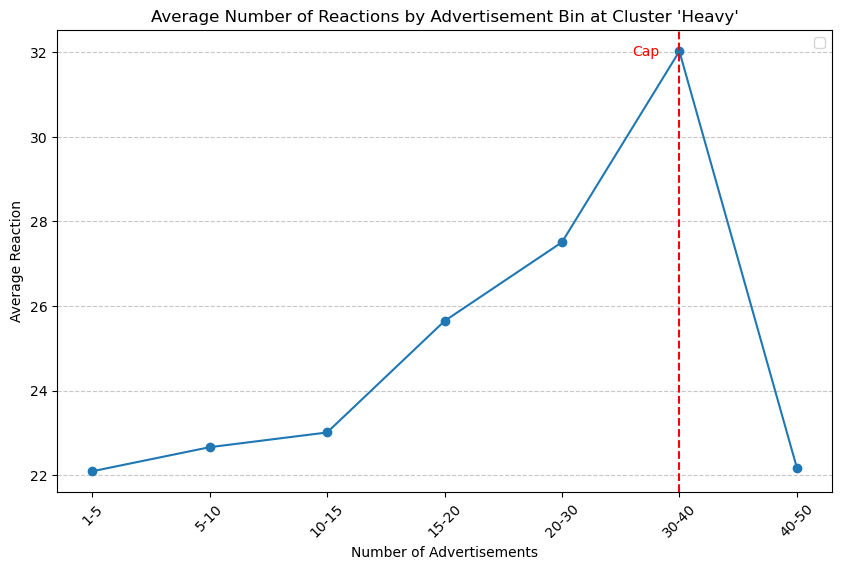

In [17]:
# Calculate the average reactions per bin
heavy_totale_avg_reactions_per_bin = heavy.groupby('freq_bins')['freq_react'].mean()
heavy_totale_avg_reactions_per_bin_df = heavy_totale_avg_reactions_per_bin.reset_index()
heavy_totale_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
heavy_totale_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
heavy_totale_min_sample_size = 28
heavy_totale_avg_reactions_per_bin_df = heavy_totale_avg_reactions_per_bin_df[heavy_totale_avg_reactions_per_bin_df['Sample Size'] >= heavy_totale_min_sample_size]

print(heavy_totale_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(heavy_totale_avg_reactions_per_bin_df['Frequency Bin'], heavy_totale_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=5, color='r', linestyle='--')
plt.text(4.6, 32, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Heavy'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster medium

In [18]:
medium[['freq_totale','freq_tv', 'freq_prog', 'freq_react','Order', 'Product Page View', 'Add to cart']].describe()

,freq_totale,freq_tv,freq_prog,freq_react,Order,Product Page View,Add to cart
count,10218.000000,10218.000000,10218.000000,10218.000000,10218.000000,10218.000000,10218.000000
mean,7.289685,3.346937,3.942748,9.677334,1.372284,6.270699,2.034351
std,8.188040,5.541228,6.102157,8.949726,1.461182,7.356664,2.085313
min,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,4.000000,0.000000,2.000000,1.000000
50%,4.000000,2.000000,2.000000,7.000000,1.000000,4.000000,2.000000
75%,9.000000,3.000000,4.000000,12.000000,2.000000,8.000000,3.000000
max,163.000000,162.000000,131.000000,137.000000,20.000000,127.000000,27.000000


In [19]:
# Create the binned column
medium['freq_bins'] = pd.cut(medium['freq_totale'], bins=bins, labels=labels, right=False)

# Verify the bins
print(medium[['freq_totale', 'freq_bins']].head())

    freq_totale freq_bins
1             2       1-5
5             5      5-10
8             5      5-10
11            7      5-10
12           13     10-15


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\515755842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['freq_bins'] = pd.cut(medium['freq_totale'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\906820661.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_totale_avg_reactions_per_bin = medium.groupby('freq_bins')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\906820661.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_totale_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins
1-5         9.309119
5-10        9.730810
10-15      10.405634
15-20      10.304505
20-30      10.869469
30-40       9.787402
40-50       8.285714
50-100     12.000000
100-200     7.000000
Name: freq_react, dtype: float64


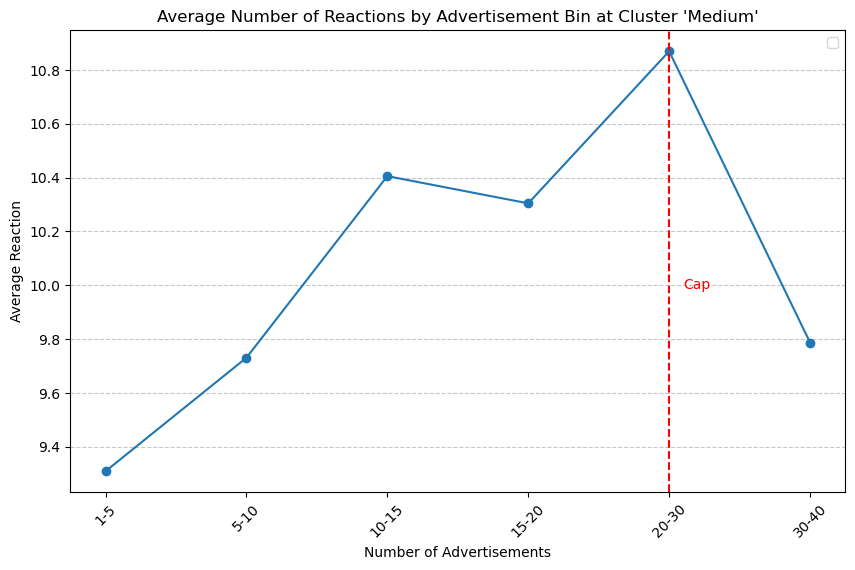

In [25]:
# Calculate the average reactions per bin
medium_totale_avg_reactions_per_bin = medium.groupby('freq_bins')['freq_react'].mean()
medium_totale_avg_reactions_per_bin_df = medium_totale_avg_reactions_per_bin.reset_index()
medium_totale_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
medium_totale_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
medium_totale_min_sample_size = 100
medium_totale_avg_reactions_per_bin_df = medium_totale_avg_reactions_per_bin_df[medium_totale_avg_reactions_per_bin_df['Sample Size'] >= medium_totale_min_sample_size]

print(medium_totale_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(medium_totale_avg_reactions_per_bin_df['Frequency Bin'], medium_totale_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=4, color='r', linestyle='--')
plt.text(4.1, 10.0, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Medium'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster light

In [26]:
light[['freq_totale','freq_tv', 'freq_prog', 'freq_react','Order', 'Product Page View', 'Add to cart']].describe()

,freq_totale,freq_tv,freq_prog,freq_react,Order,Product Page View,Add to cart
count,19395.000000,19395.000000,19395.000000,19395.000000,19395.000000,19395.000000,19395.000000
mean,8.401908,3.440681,4.961227,2.178345,0.031348,1.966074,0.180923
std,9.624528,5.687972,7.776483,2.432338,0.178356,2.208990,0.537744
min,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,5.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000
75%,10.000000,4.000000,5.000000,2.000000,0.000000,2.000000,0.000000
max,160.000000,158.000000,135.000000,68.000000,2.000000,61.000000,12.000000


In [27]:
# Create the binned column
light['freq_bins'] = pd.cut(light['freq_totale'], bins=bins, labels=labels, right=False)

# Verify the bins
print(light[['freq_totale', 'freq_bins']].head())

    freq_totale freq_bins
3             3       1-5
4             5      5-10
9             4       1-5
14            3       1-5
15            7      5-10


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3088195742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['freq_bins'] = pd.cut(light['freq_totale'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1888579165.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_totale_avg_reactions_per_bin = light.groupby('freq_bins')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1888579165.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_totale_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins
1-5        2.186631
5-10       2.171995
10-15      2.204914
15-20      2.163462
20-30      2.072761
30-40      2.051220
40-50      2.403409
50-100     2.401235
100-200    3.222222
Name: freq_react, dtype: float64


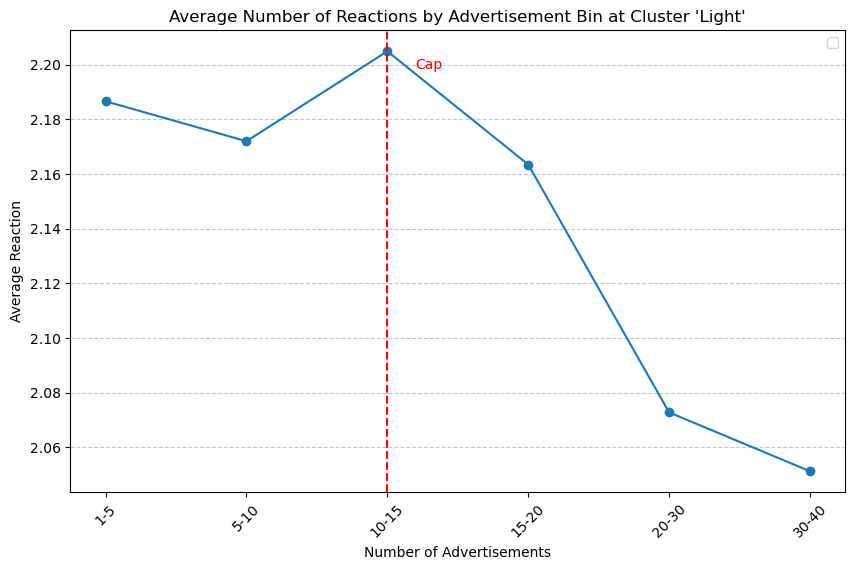

In [28]:
# Calculate the average reactions per bin
light_totale_avg_reactions_per_bin = light.groupby('freq_bins')['freq_react'].mean()
light_totale_avg_reactions_per_bin_df = light_totale_avg_reactions_per_bin.reset_index()
light_totale_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
light_totale_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
light_totale_min_sample_size = 200
light_totale_avg_reactions_per_bin_df = light_totale_avg_reactions_per_bin_df[light_totale_avg_reactions_per_bin_df['Sample Size'] >= light_totale_min_sample_size]

print(light_totale_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(light_totale_avg_reactions_per_bin_df['Frequency Bin'], light_totale_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=2, color='r', linestyle='--')
plt.text(2.2, 2.2, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Light'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

### Capping Value analysis of "freq_tv"

#### Cluster heavy

In [29]:
# Create the binned column
heavy['freq_bins_tv'] = pd.cut(heavy['freq_tv'], bins=bins, labels=labels, right=False)

# Verify the bins
print(heavy[['freq_totale', 'freq_bins_tv']].head())

    freq_totale freq_bins_tv
0             3          1-5
2             2          1-5
6             2          1-5
7            12        10-15
10            2          1-5


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1066478557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['freq_bins_tv'] = pd.cut(heavy['freq_tv'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2644330064.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_tv_avg_reactions_per_bin = heavy.groupby('freq_bins_tv')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2644330064.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_tv_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_tv')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins_tv
1-5        23.335667
5-10       21.179217
10-15      22.893401
15-20      22.315789
20-30      19.609756
30-40      19.619048
40-50      26.384615
50-100     36.444444
100-200          NaN
Name: freq_react, dtype: float64


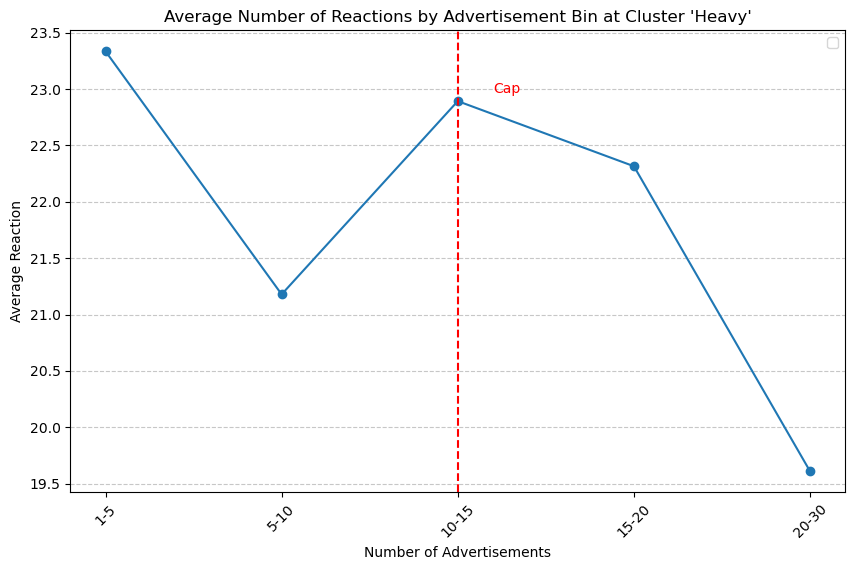

In [30]:
# Calculate the average reactions per bin
heavy_tv_avg_reactions_per_bin = heavy.groupby('freq_bins_tv')['freq_react'].mean()
heavy_tv_avg_reactions_per_bin_df = heavy_tv_avg_reactions_per_bin.reset_index()
heavy_tv_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
heavy_tv_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_tv')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
heavy_tv_min_sample_size = 60
heavy_tv_avg_reactions_per_bin_df = heavy_tv_avg_reactions_per_bin_df[heavy_tv_avg_reactions_per_bin_df['Sample Size'] >= heavy_tv_min_sample_size]

print(heavy_tv_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(heavy_tv_avg_reactions_per_bin_df['Frequency Bin'], heavy_tv_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=2, color='r', linestyle='--')
plt.text(2.2, 23, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Heavy'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster medium

In [31]:
# Create the binned column
medium['freq_bins_tv'] = pd.cut(medium['freq_tv'], bins=bins, labels=labels, right=False)

# Verify the bins
print(medium[['freq_tv', 'freq_bins_tv']].head())

    freq_tv freq_bins_tv
1         1          1-5
5         4          1-5
8         2          1-5
11        1          1-5
12       12        10-15


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1084584100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['freq_bins_tv'] = pd.cut(medium['freq_tv'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2850490372.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_tv_avg_reactions_per_bin = medium.groupby('freq_bins_tv')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2850490372.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_tv_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_tv')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins_tv
1-5        9.789853
5-10       9.345679
10-15      8.867052
15-20      8.732877
20-30      9.008130
30-40      9.100000
40-50      8.944444
50-100     9.714286
100-200    7.000000
Name: freq_react, dtype: float64


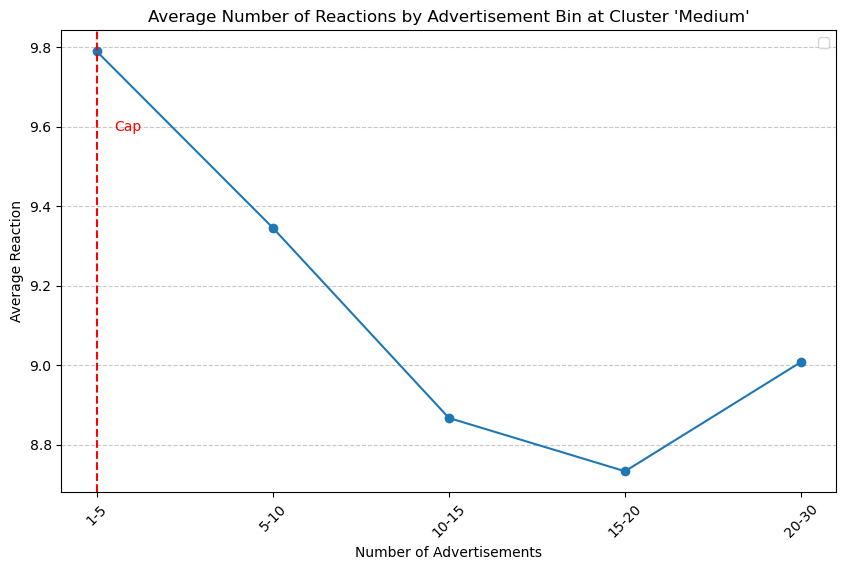

In [32]:
# Calculate the average reactions per bin
medium_tv_avg_reactions_per_bin = medium.groupby('freq_bins_tv')['freq_react'].mean()
medium_tv_avg_reactions_per_bin_df = medium_tv_avg_reactions_per_bin.reset_index()
medium_tv_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
medium_tv_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_tv')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
medium_tv_min_sample_size = 60
medium_tv_avg_reactions_per_bin_df = medium_tv_avg_reactions_per_bin_df[medium_tv_avg_reactions_per_bin_df['Sample Size'] >= medium_tv_min_sample_size]

print(medium_tv_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(medium_tv_avg_reactions_per_bin_df['Frequency Bin'], medium_tv_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0.1, 9.6, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Medium'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster light

In [33]:
# Create the binned column
light['freq_bins_tv'] = pd.cut(light['freq_tv'], bins=bins, labels=labels, right=False)

# Verify the bins
print(light[['freq_tv', 'freq_bins_tv']].head())

    freq_tv freq_bins_tv
3         1          1-5
4         4          1-5
9         1          1-5
14        2          1-5
15        6         5-10


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2550076733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['freq_bins_tv'] = pd.cut(light['freq_tv'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1317585663.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_tv_avg_reactions_per_bin = light.groupby('freq_bins_tv')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1317585663.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_tv_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_tv')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins_tv
1-5        2.192831
5-10       2.101801
10-15      2.107296
15-20      2.123134
20-30      1.940678
30-40      2.824324
40-50      2.774194
50-100     2.288889
100-200    3.500000
Name: freq_react, dtype: float64


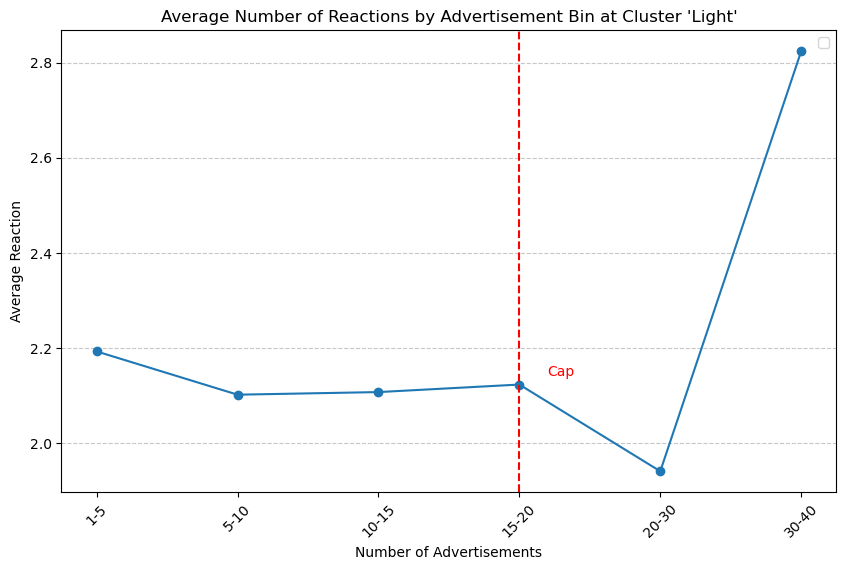

In [74]:
# Calculate the average reactions per bin
light_tv_avg_reactions_per_bin = light.groupby('freq_bins_tv')['freq_react'].mean()
light_tv_avg_reactions_per_bin_df = light_tv_avg_reactions_per_bin.reset_index()
light_tv_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
light_tv_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_tv')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
light_tv_min_sample_size = 60
light_tv_avg_reactions_per_bin_df = light_tv_avg_reactions_per_bin_df[light_tv_avg_reactions_per_bin_df['Sample Size'] >= light_tv_min_sample_size]

print(light_tv_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(light_tv_avg_reactions_per_bin_df['Frequency Bin'], light_tv_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=3, color='r', linestyle='--')
plt.text(3.2, 2.15, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Light'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

### Capping Value analysis of "freq_prog"

#### Cluster heavy

In [36]:
# Create the binned column
heavy['freq_bins_prog'] = pd.cut(heavy['freq_prog'], bins=bins, labels=labels, right=False)

# Verify the bins
print(heavy[['freq_prog', 'freq_bins_prog']].head())

    freq_prog freq_bins_prog
0           1            1-5
2           1            1-5
6           1            1-5
7           2            1-5
10          1            1-5


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\762495999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['freq_bins_prog'] = pd.cut(heavy['freq_prog'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\804648142.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_prog_avg_reactions_per_bin = heavy.groupby('freq_bins_prog')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\804648142.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_prog_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_prog')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins_prog
1-5        21.844348
5-10       24.637016
10-15      24.979885
15-20      33.006494
20-30      32.605263
30-40      34.923077
40-50      28.928571
50-100     25.250000
100-200          NaN
Name: freq_react, dtype: float64


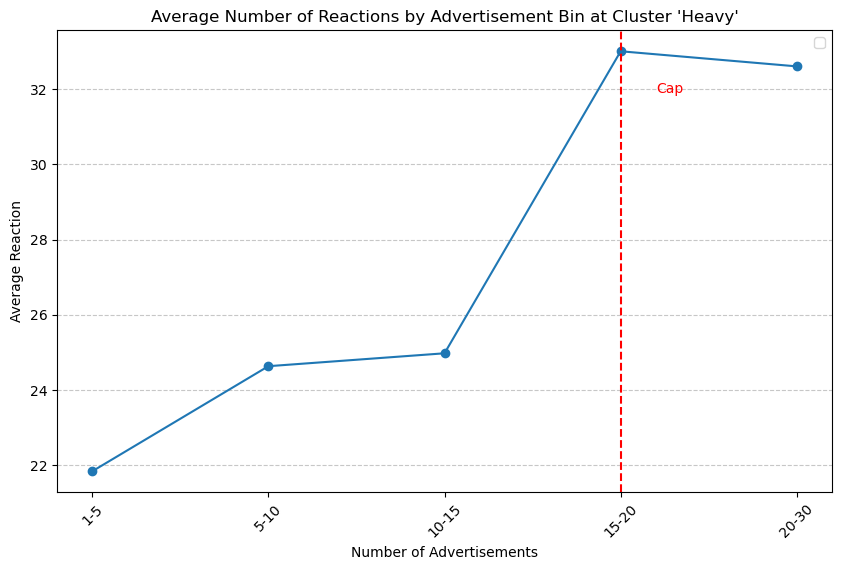

In [37]:
# Calculate the average reactions per bin
heavy_prog_avg_reactions_per_bin = heavy.groupby('freq_bins_prog')['freq_react'].mean()
heavy_prog_avg_reactions_per_bin_df = heavy_prog_avg_reactions_per_bin.reset_index()
heavy_prog_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
heavy_prog_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_prog')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
heavy_prog_min_sample_size = 60
heavy_prog_avg_reactions_per_bin_df = heavy_prog_avg_reactions_per_bin_df[heavy_prog_avg_reactions_per_bin_df['Sample Size'] >= heavy_prog_min_sample_size]

print(heavy_prog_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(heavy_prog_avg_reactions_per_bin_df['Frequency Bin'], heavy_prog_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=3, color='r', linestyle='--')
plt.text(3.2, 32, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Heavy'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster medium

In [38]:
# Create the binned column
medium['freq_bins_prog'] = pd.cut(medium['freq_prog'], bins=bins, labels=labels, right=False)

# Verify the bins
print(medium[['freq_prog', 'freq_bins_prog']].head())

    freq_prog freq_bins_prog
1           1            1-5
5           1            1-5
8           3            1-5
11          6           5-10
12          1            1-5


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1815206216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['freq_bins_prog'] = pd.cut(medium['freq_prog'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3680310166.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_prog_avg_reactions_per_bin = medium.groupby('freq_bins_prog')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3680310166.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_prog_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_prog')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins_prog
1-5         9.261517
5-10       10.785320
10-15      10.944341
15-20      11.923358
20-30      12.300518
30-40       8.586957
40-50       9.300000
50-100     15.650000
100-200     7.000000
Name: freq_react, dtype: float64


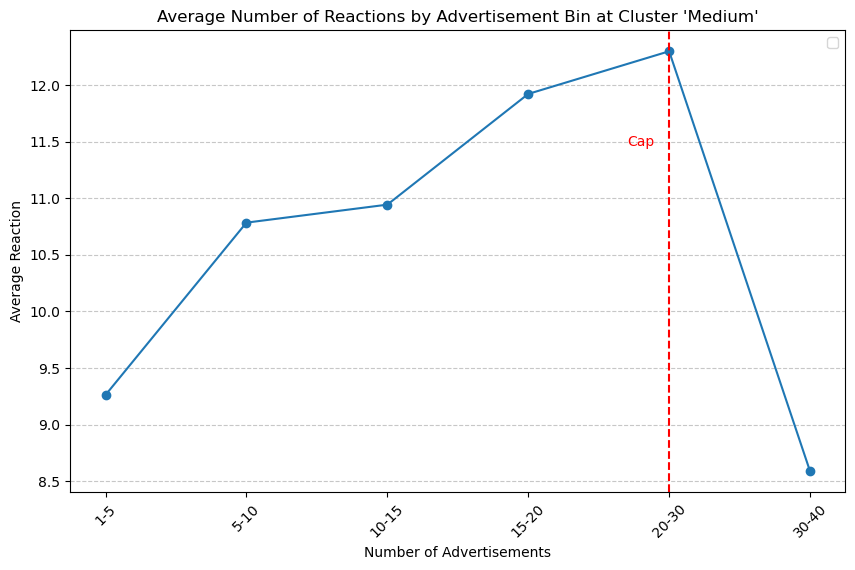

In [45]:
# Calculate the average reactions per bin
medium_prog_avg_reactions_per_bin = medium.groupby('freq_bins_prog')['freq_react'].mean()
medium_prog_avg_reactions_per_bin_df = medium_prog_avg_reactions_per_bin.reset_index()
medium_prog_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
medium_prog_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_prog')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
medium_prog_min_sample_size = 25
medium_prog_avg_reactions_per_bin_df = medium_prog_avg_reactions_per_bin_df[medium_prog_avg_reactions_per_bin_df['Sample Size'] >= medium_prog_min_sample_size]

print(medium_prog_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(medium_prog_avg_reactions_per_bin_df['Frequency Bin'], medium_prog_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=4, color='r', linestyle='--')
plt.text(3.7, 11.5, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Medium'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster light

In [46]:
# Create the binned column
light['freq_bins_prog'] = pd.cut(light['freq_prog'], bins=bins, labels=labels, right=False)

# Verify the bins
print(light[['freq_prog', 'freq_bins_prog']].head())

    freq_prog freq_bins_prog
3           2            1-5
4           1            1-5
9           3            1-5
14          1            1-5
15          1            1-5


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\918585015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['freq_bins_prog'] = pd.cut(light['freq_prog'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1246973580.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_prog_avg_reactions_per_bin = light.groupby('freq_bins_tv')['freq_react'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1246973580.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_prog_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_tv')['freq_react'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


freq_bins_tv
1-5        2.192831
5-10       2.101801
10-15      2.107296
15-20      2.123134
20-30      1.940678
30-40      2.824324
40-50      2.774194
50-100     2.288889
100-200    3.500000
Name: freq_react, dtype: float64


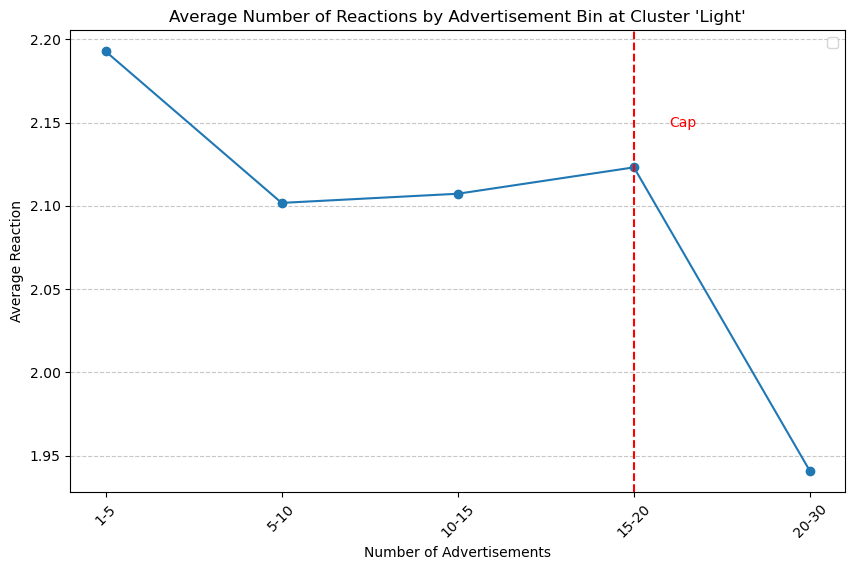

In [48]:
# Calculate the average reactions per bin
light_prog_avg_reactions_per_bin = light.groupby('freq_bins_tv')['freq_react'].mean()
light_prog_avg_reactions_per_bin_df = light_prog_avg_reactions_per_bin.reset_index()
light_prog_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Reactions']

# Add the sample size (number of people per bin)
light_prog_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_tv')['freq_react'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
light_prog_min_sample_size = 200
light_prog_avg_reactions_per_bin_df = light_prog_avg_reactions_per_bin_df[light_prog_avg_reactions_per_bin_df['Sample Size'] >= light_prog_min_sample_size]

print(light_prog_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(light_prog_avg_reactions_per_bin_df['Frequency Bin'], light_prog_avg_reactions_per_bin_df['Average Reactions'], marker='o', linestyle='-')
plt.axvline(x=3, color='r', linestyle='--')
plt.text(3.2, 2.15, f'Cap', color='r', va='center', ha='left')
plt.title("Average Number of Reactions by Advertisement Bin at Cluster 'Light'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

## Plotting Weighted Cap Curve

In [76]:
# Reuse existing bins for advertisement frequency
bins = [1, 5, 10, 15, 20, 30, 40, 50, 100, 200]
labels = ["1-5", "5-10", "10-15", "15-20", "20-30", "30-40", "40-50", "50-100", "100-200"]

### Dataset heavy

In [77]:
# Define weights
weight_page_view = 1
weight_add_to_cart = 2
weight_order = 3

# Normalize each attribute to the range [0, 1]
heavy['Product Page View Norm'] = heavy['Product Page View'] / heavy['Product Page View'].max()
heavy['Add to cart Norm'] = heavy['Add to cart'] / heavy['Add to cart'].max()
heavy['Order Norm'] = heavy['Order'] / heavy['Order'].max()

# Calculate the weighted reaction using normalized values
heavy['weighted_reaction'] = (
    heavy['Product Page View Norm'] * weight_page_view +
    heavy['Add to cart Norm'] * weight_add_to_cart +
    heavy['Order Norm'] * weight_order
)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1954476167.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['Product Page View Norm'] = heavy['Product Page View'] / heavy['Product Page View'].max()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1954476167.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['Add to cart Norm'] = heavy['Add to cart'] / heavy['Add to cart'].max()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1954476167.py:9: SettingWithCopyWarning: 
A value is trying to

### Dataset medium

In [78]:
# Define weights
weight_page_view = 1
weight_add_to_cart = 2
weight_order = 3

# Normalize each attribute to the range [0, 1]
medium['Product Page View Norm'] = medium['Product Page View'] / medium['Product Page View'].max()
medium['Add to cart Norm'] = medium['Add to cart'] / medium['Add to cart'].max()
medium['Order Norm'] = medium['Order'] / medium['Order'].max()

# Calculate the weighted reaction using normalized values
medium['weighted_reaction'] = (
    medium['Product Page View Norm'] * weight_page_view +
    medium['Add to cart Norm'] * weight_add_to_cart +
    medium['Order Norm'] * weight_order
)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\88185579.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['Product Page View Norm'] = medium['Product Page View'] / medium['Product Page View'].max()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\88185579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['Add to cart Norm'] = medium['Add to cart'] / medium['Add to cart'].max()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\88185579.py:9: SettingWithCopyWarning: 
A value is trying to

### Dataset light

In [79]:
# Define weights
weight_page_view = 1
weight_add_to_cart = 2
weight_order = 3

# Normalize each attribute to the range [0, 1]
light['Product Page View Norm'] = light['Product Page View'] / light['Product Page View'].max()
light['Add to cart Norm'] = light['Add to cart'] / light['Add to cart'].max()
light['Order Norm'] = light['Order'] / light['Order'].max()

# Calculate the weighted reaction using normalized values
light['weighted_reaction'] = (
    light['Product Page View Norm'] * weight_page_view +
    light['Add to cart Norm'] * weight_add_to_cart +
    light['Order Norm'] * weight_order
)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\753894897.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['Product Page View Norm'] = light['Product Page View'] / light['Product Page View'].max()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\753894897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['Add to cart Norm'] = light['Add to cart'] / light['Add to cart'].max()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\753894897.py:9: SettingWithCopyWarning: 
A value is trying to be

### Weighted Capping Value analysis of "freq_totale"

#### Cluster heavy

In [80]:
# Bin the freq_total column
heavy['freq_bins_weighted_totale'] = pd.cut(heavy['freq_totale'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1467744021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['freq_bins_weighted_totale'] = pd.cut(heavy['freq_totale'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3337245454.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_weighted_totale_avg_reactions_per_bin = heavy.groupby('freq_bins_weighted_totale')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3337245454.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_weighted_totale_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_weighted_totale')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() i

freq_bins_weighted_totale
1-5        0.530846
5-10       0.529257
10-15      0.554561
15-20      0.595785
20-30      0.644217
30-40      0.730439
40-50      0.521666
50-100     0.577761
100-200         NaN
Name: weighted_reaction, dtype: float64


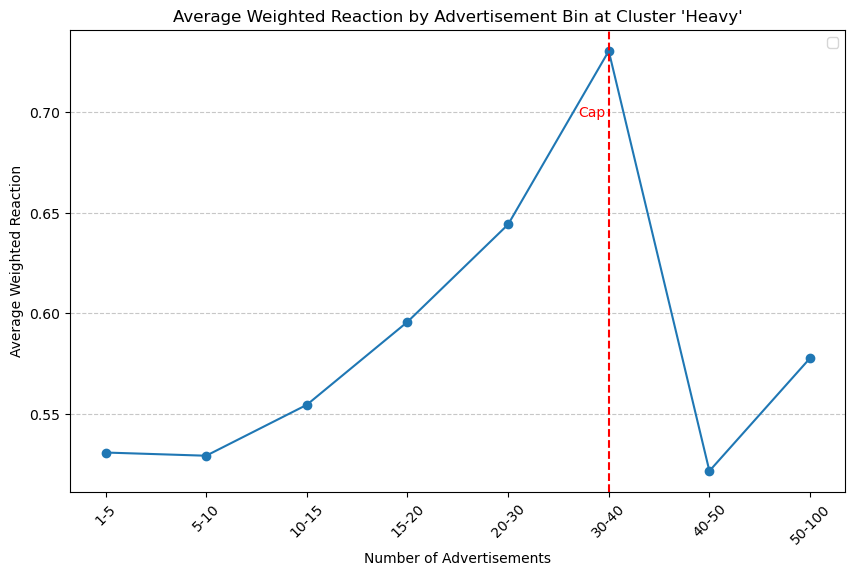

In [81]:
# Calculate the average reactions per bin
heavy_weighted_totale_avg_reactions_per_bin = heavy.groupby('freq_bins_weighted_totale')['weighted_reaction'].mean()
heavy_weighted_totale_avg_reactions_per_bin_df = heavy_weighted_totale_avg_reactions_per_bin.reset_index()
heavy_weighted_totale_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
heavy_weighted_totale_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_weighted_totale')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
heavy_totale_min_sample_size = 20
heavy_weighted_totale_avg_reactions_per_bin_df = heavy_weighted_totale_avg_reactions_per_bin_df[heavy_weighted_totale_avg_reactions_per_bin_df['Sample Size'] >= heavy_totale_min_sample_size]

print(heavy_weighted_totale_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(heavy_weighted_totale_avg_reactions_per_bin_df['Frequency Bin'], heavy_weighted_totale_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=5, color='r', linestyle='--')
plt.text(4.7, 0.700, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Heavy'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster medium

In [82]:
# Bin the freq_total column
medium['freq_bins_weighted_totale'] = pd.cut(medium['freq_totale'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2791403549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['freq_bins_weighted_totale'] = pd.cut(medium['freq_totale'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2339301096.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_weighted_totale_avg_reactions_per_bin = medium.groupby('freq_bins_weighted_totale')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2339301096.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_weighted_totale_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_weighted_totale')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend

freq_bins_weighted_totale
1-5        0.394078
5-10       0.401513
10-15      0.443987
15-20      0.446188
20-30      0.442742
30-40      0.412837
40-50      0.348157
50-100     0.316702
100-200    0.225481
Name: weighted_reaction, dtype: float64


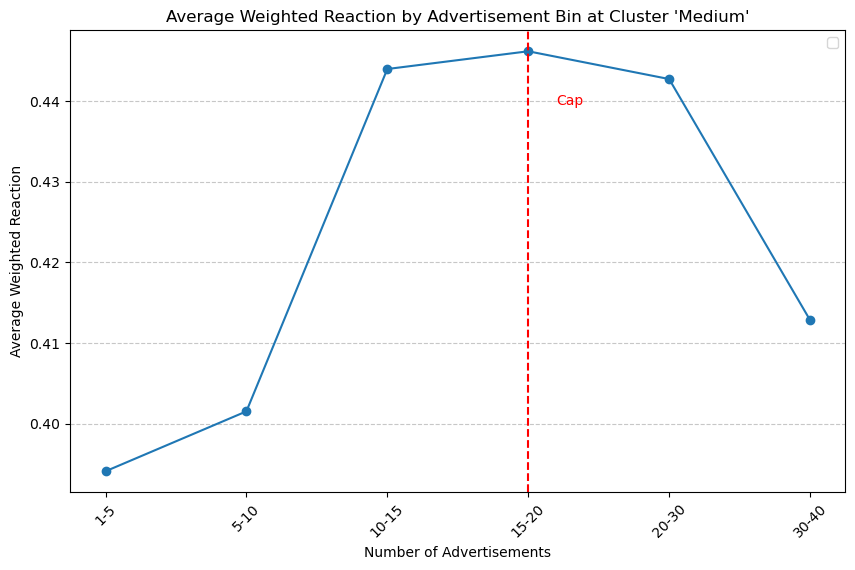

In [83]:
# Calculate the average reactions per bin
medium_weighted_totale_avg_reactions_per_bin = medium.groupby('freq_bins_weighted_totale')['weighted_reaction'].mean()
medium_weighted_totale_avg_reactions_per_bin_df = medium_weighted_totale_avg_reactions_per_bin.reset_index()
medium_weighted_totale_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
medium_weighted_totale_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_weighted_totale')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
medium_totale_min_sample_size = 60
medium_weighted_totale_avg_reactions_per_bin_df = medium_weighted_totale_avg_reactions_per_bin_df[medium_weighted_totale_avg_reactions_per_bin_df['Sample Size'] >= medium_totale_min_sample_size]

print(medium_weighted_totale_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(medium_weighted_totale_avg_reactions_per_bin_df['Frequency Bin'], medium_weighted_totale_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=3, color='r', linestyle='--')
plt.text(3.2, 0.44, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Medium'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster light

In [84]:
# Bin the freq_total column
light['freq_bins_weighted_totale'] = pd.cut(light['freq_totale'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1269153757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['freq_bins_weighted_totale'] = pd.cut(light['freq_totale'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1632140775.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_weighted_totale_avg_reactions_per_bin = light.groupby('freq_bins_weighted_totale')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1632140775.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_weighted_totale_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_weighted_totale')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() i

freq_bins_weighted_totale
1-5        0.111861
5-10       0.117729
10-15      0.113318
15-20      0.094258
20-30      0.089185
30-40      0.054058
40-50      0.060637
50-100     0.081680
100-200    0.102914
Name: weighted_reaction, dtype: float64


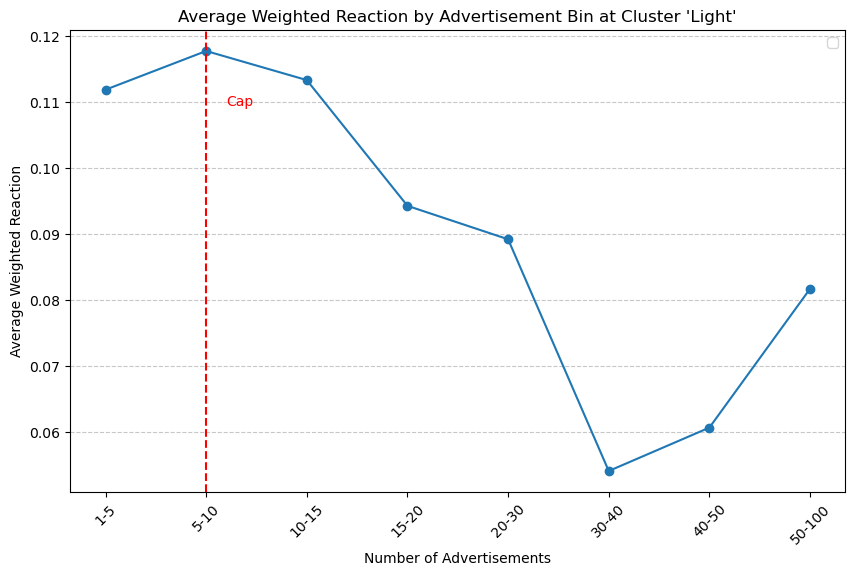

In [85]:
# Calculate the average reactions per bin
light_weighted_totale_avg_reactions_per_bin = light.groupby('freq_bins_weighted_totale')['weighted_reaction'].mean()
light_weighted_totale_avg_reactions_per_bin_df = light_weighted_totale_avg_reactions_per_bin.reset_index()
light_weighted_totale_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
light_weighted_totale_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_weighted_totale')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
light_totale_min_sample_size = 60
light_weighted_totale_avg_reactions_per_bin_df = light_weighted_totale_avg_reactions_per_bin_df[light_weighted_totale_avg_reactions_per_bin_df['Sample Size'] >= light_totale_min_sample_size]

print(light_weighted_totale_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(light_weighted_totale_avg_reactions_per_bin_df['Frequency Bin'], light_weighted_totale_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=1, color='r', linestyle='--')
plt.text(1.2, 0.11, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Light'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

### Weighted Capping Value analysis of "freq_tv"

#### Cluster heavy

In [86]:
# Bin the freq_total column
heavy['freq_bins_weighted_tv'] = pd.cut(heavy['freq_tv'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\100466446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['freq_bins_weighted_tv'] = pd.cut(heavy['freq_tv'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1531754368.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_weighted_tv_avg_reactions_per_bin = heavy.groupby('freq_bins_weighted_tv')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1531754368.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_weighted_tv_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_weighted_tv')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no

freq_bins_weighted_tv
1-5        0.550553
5-10       0.526175
10-15      0.557966
15-20      0.471573
20-30      0.485952
30-40      0.464344
40-50      0.562094
50-100     0.596160
100-200         NaN
Name: weighted_reaction, dtype: float64


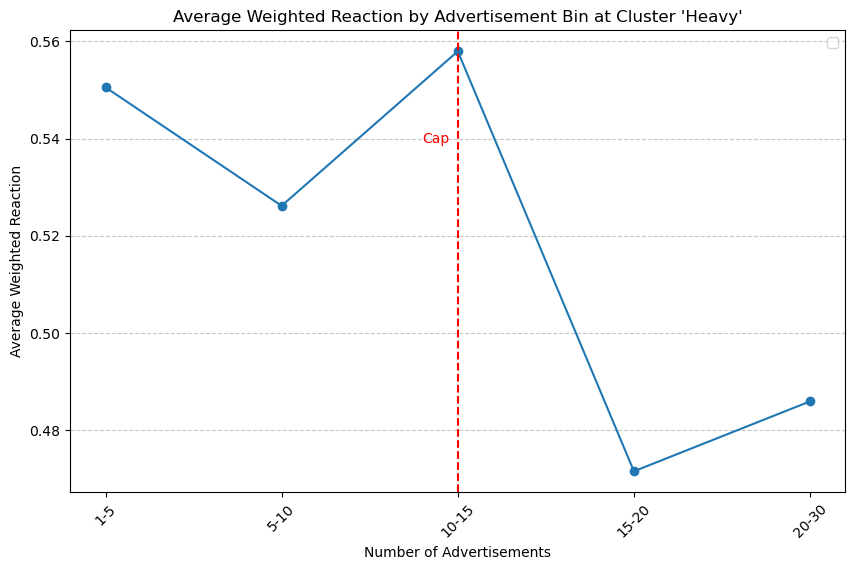

In [87]:
# Calculate the average reactions per bin
heavy_weighted_tv_avg_reactions_per_bin = heavy.groupby('freq_bins_weighted_tv')['weighted_reaction'].mean()
heavy_weighted_tv_avg_reactions_per_bin_df = heavy_weighted_tv_avg_reactions_per_bin.reset_index()
heavy_weighted_tv_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
heavy_weighted_tv_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_weighted_tv')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
heavy_tv_min_sample_size = 60
heavy_weighted_tv_avg_reactions_per_bin_df = heavy_weighted_tv_avg_reactions_per_bin_df[heavy_weighted_tv_avg_reactions_per_bin_df['Sample Size'] >= heavy_tv_min_sample_size]

print(heavy_weighted_tv_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(heavy_weighted_tv_avg_reactions_per_bin_df['Frequency Bin'], heavy_weighted_tv_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=2, color='r', linestyle='--')
plt.text(1.8, 0.54, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Heavy'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster medium

In [88]:
# Bin the freq_total column
medium['freq_bins_weighted_tv'] = pd.cut(medium['freq_tv'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\967767650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['freq_bins_weighted_tv'] = pd.cut(medium['freq_tv'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\688220265.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_weighted_tv_avg_reactions_per_bin = medium.groupby('freq_bins_weighted_tv')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\688220265.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_weighted_tv_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_weighted_tv')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with 

freq_bins_weighted_tv
1-5        0.408640
5-10       0.402353
10-15      0.373098
15-20      0.361744
20-30      0.395143
30-40      0.491746
40-50      0.360747
50-100     0.368168
100-200    0.187518
Name: weighted_reaction, dtype: float64


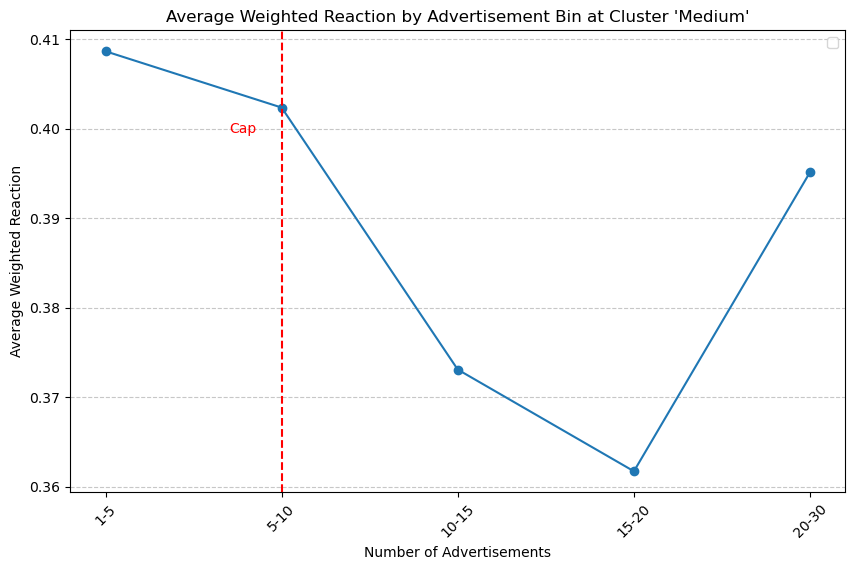

In [89]:
# Calculate the average reactions per bin
medium_weighted_tv_avg_reactions_per_bin = medium.groupby('freq_bins_weighted_tv')['weighted_reaction'].mean()
medium_weighted_tv_avg_reactions_per_bin_df = medium_weighted_tv_avg_reactions_per_bin.reset_index()
medium_weighted_tv_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
medium_weighted_tv_avg_reactions_per_bin_df['Sample Size'] = medium.groupby('freq_bins_weighted_tv')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
medium_tv_min_sample_size = 100
medium_weighted_tv_avg_reactions_per_bin_df = medium_weighted_tv_avg_reactions_per_bin_df[medium_weighted_tv_avg_reactions_per_bin_df['Sample Size'] >= medium_tv_min_sample_size]

print(medium_weighted_tv_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(medium_weighted_tv_avg_reactions_per_bin_df['Frequency Bin'], medium_weighted_tv_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=1, color='r', linestyle='--')
plt.text(0.7, 0.40, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Medium'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster light

In [90]:
# Bin the freq_total column
light['freq_bins_weighted_tv'] = pd.cut(light['freq_tv'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\182372005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['freq_bins_weighted_tv'] = pd.cut(light['freq_tv'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3417484486.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_weighted_tv_avg_reactions_per_bin = light.groupby('freq_bins_weighted_tv')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3417484486.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_weighted_tv_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_weighted_tv')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no

freq_bins_weighted_tv
1-5        0.108331
5-10       0.115647
10-15      0.102766
15-20      0.097739
20-30      0.151581
30-40      0.088687
40-50      0.093954
50-100     0.143534
100-200    0.170082
Name: weighted_reaction, dtype: float64


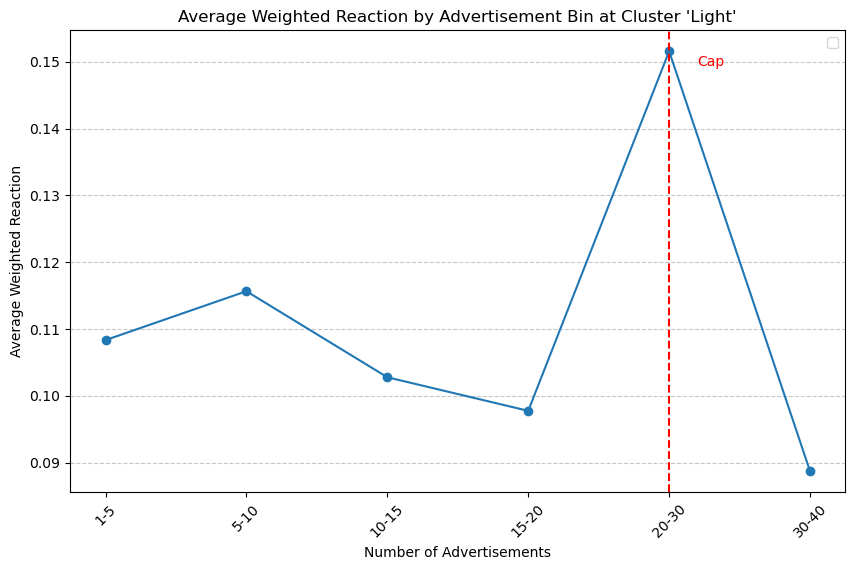

In [91]:
# Calculate the average reactions per bin
light_weighted_tv_avg_reactions_per_bin = light.groupby('freq_bins_weighted_tv')['weighted_reaction'].mean()
light_weighted_tv_avg_reactions_per_bin_df = light_weighted_tv_avg_reactions_per_bin.reset_index()
light_weighted_tv_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
light_weighted_tv_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_weighted_tv')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
light_tv_min_sample_size = 60
light_weighted_tv_avg_reactions_per_bin_df = light_weighted_tv_avg_reactions_per_bin_df[light_weighted_tv_avg_reactions_per_bin_df['Sample Size'] >= light_tv_min_sample_size]

print(light_weighted_tv_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(light_weighted_tv_avg_reactions_per_bin_df['Frequency Bin'], light_weighted_tv_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=4, color='r', linestyle='--')
plt.text(4.2, 0.15, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Light'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

### Weighted Capping Value analysis of "freq_prog"

#### Cluster heavy

In [92]:
# Bin the freq_total column
heavy['freq_bins_weighted_prog'] = pd.cut(heavy['freq_prog'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\569154236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heavy['freq_bins_weighted_prog'] = pd.cut(heavy['freq_prog'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2720177181.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_weighted_prog_avg_reactions_per_bin = heavy.groupby('freq_bins_weighted_prog')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\2720177181.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heavy_weighted_prog_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_weighted_prog')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

freq_bins_weighted_prog
1-5        0.525178
5-10       0.559195
10-15      0.582371
15-20      0.721698
20-30      0.795974
30-40      0.778463
40-50      0.640417
50-100     0.491416
100-200         NaN
Name: weighted_reaction, dtype: float64


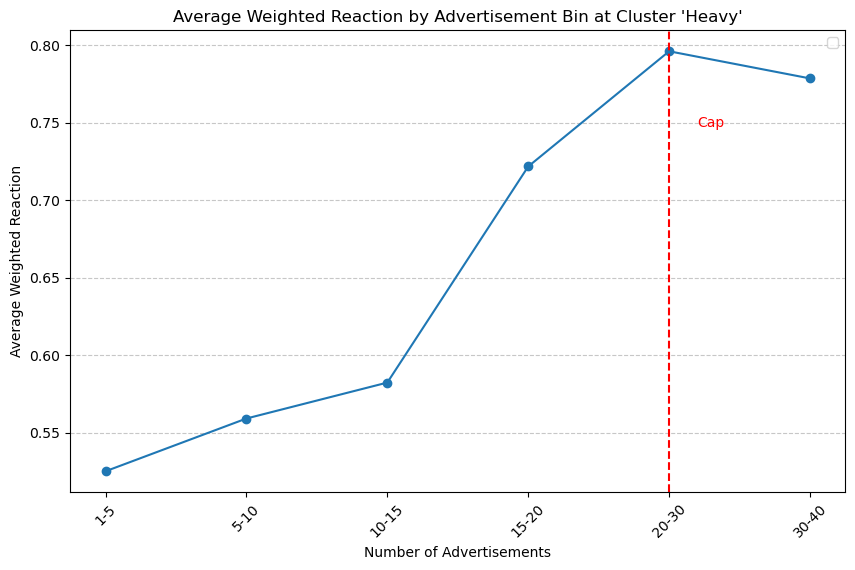

In [93]:
# Calculate the average reactions per bin
heavy_weighted_prog_avg_reactions_per_bin = heavy.groupby('freq_bins_weighted_prog')['weighted_reaction'].mean()
heavy_weighted_prog_avg_reactions_per_bin_df = heavy_weighted_prog_avg_reactions_per_bin.reset_index()
heavy_weighted_prog_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
heavy_weighted_prog_avg_reactions_per_bin_df['Sample Size'] = heavy.groupby('freq_bins_weighted_prog')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
heavy_prog_min_sample_size = 50
heavy_weighted_prog_avg_reactions_per_bin_df = heavy_weighted_prog_avg_reactions_per_bin_df[heavy_weighted_prog_avg_reactions_per_bin_df['Sample Size'] >= heavy_prog_min_sample_size]

print(heavy_weighted_prog_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(heavy_weighted_prog_avg_reactions_per_bin_df['Frequency Bin'], heavy_weighted_prog_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=4, color='r', linestyle='--')
plt.text(4.2, 0.75, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Heavy'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### Cluster medium

In [94]:
# Bin the freq_total column
medium['freq_bins_weighted_prog'] = pd.cut(medium['freq_prog'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\4275730025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['freq_bins_weighted_prog'] = pd.cut(medium['freq_prog'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1919965398.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_weighted_prog_avg_reactions_per_bin = medium.groupby('freq_bins_weighted_prog')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\1919965398.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medium_weighted_prog_avg_reactions_per_bi_df['Sample Size'] = medium.groupby('freq_bins_weighted_prog')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is cal

freq_bins_weighted_prog
1-5        0.390634
5-10       0.447026
10-15      0.481031
15-20      0.494153
20-30      0.488713
30-40      0.221764
40-50      0.290998
50-100     0.316855
100-200    0.263444
Name: weighted_reaction, dtype: float64


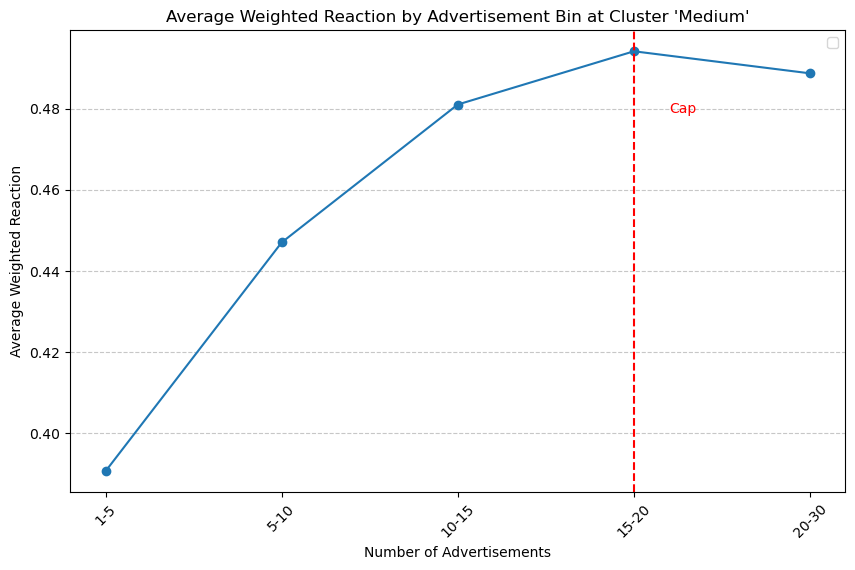

In [95]:
# Calculate the average reactions per bin
medium_weighted_prog_avg_reactions_per_bin = medium.groupby('freq_bins_weighted_prog')['weighted_reaction'].mean()
medium_weighted_prog_avg_reactions_per_bi_df = medium_weighted_prog_avg_reactions_per_bin.reset_index()
medium_weighted_prog_avg_reactions_per_bi_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
medium_weighted_prog_avg_reactions_per_bi_df['Sample Size'] = medium.groupby('freq_bins_weighted_prog')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
medium_prog_min_sample_size = 60
medium_weighted_prog_avg_reactions_per_bi_df = medium_weighted_prog_avg_reactions_per_bi_df[medium_weighted_prog_avg_reactions_per_bi_df['Sample Size'] >= medium_prog_min_sample_size]

print(medium_weighted_prog_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(medium_weighted_prog_avg_reactions_per_bi_df['Frequency Bin'], medium_weighted_prog_avg_reactions_per_bi_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=3, color='r', linestyle='--')
plt.text(3.2, 0.48, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Medium'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()

#### CLuster light

In [96]:
# Bin the freq_total column
light['freq_bins_weighted_prog'] = pd.cut(light['freq_prog'], bins=bins, labels=labels, right=False)

C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3050466920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light['freq_bins_weighted_prog'] = pd.cut(light['freq_prog'], bins=bins, labels=labels, right=False)


C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3150192960.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_weighted_prog_avg_reactions_per_bin = light.groupby('freq_bins_weighted_prog')['weighted_reaction'].mean()
C:\Users\lenna\AppData\Local\Temp\ipykernel_46032\3150192960.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  light_weighted_prog_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_weighted_prog')['weighted_reaction'].count().values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called

freq_bins_weighted_prog
1-5        0.115255
5-10       0.109880
10-15      0.103293
15-20      0.062788
20-30      0.069929
30-40      0.045334
40-50      0.056974
50-100     0.063227
100-200    0.057377
Name: weighted_reaction, dtype: float64


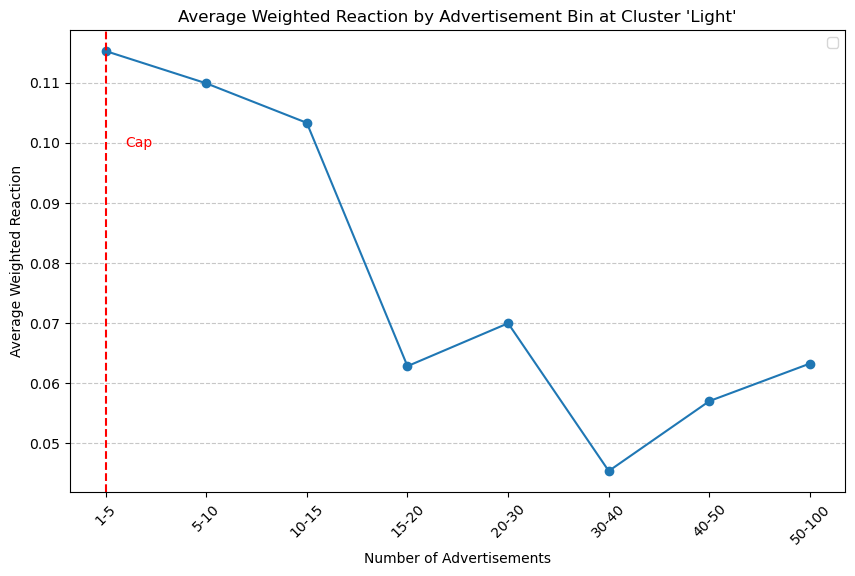

In [97]:
# Calculate the average reactions per bin
light_weighted_prog_avg_reactions_per_bin = light.groupby('freq_bins_weighted_prog')['weighted_reaction'].mean()
light_weighted_prog_avg_reactions_per_bin_df = light_weighted_prog_avg_reactions_per_bin.reset_index()
light_weighted_prog_avg_reactions_per_bin_df.columns = ['Frequency Bin', 'Average Weighted Reaction']

# Add the sample size (number of people per bin)
light_weighted_prog_avg_reactions_per_bin_df['Sample Size'] = light.groupby('freq_bins_weighted_prog')['weighted_reaction'].count().values

# Filter out bins with very few observations. This is based on Empirical Approach.
light_prog_min_sample_size = 60
light_weighted_prog_avg_reactions_per_bin_df = light_weighted_prog_avg_reactions_per_bin_df[light_weighted_prog_avg_reactions_per_bin_df['Sample Size'] >= light_prog_min_sample_size]

print(light_weighted_prog_avg_reactions_per_bin)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(light_weighted_prog_avg_reactions_per_bin_df['Frequency Bin'], light_weighted_prog_avg_reactions_per_bin_df['Average Weighted Reaction'], marker='o', linestyle='-')
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0.2, 0.10, f'Cap', color='r', va='center', ha='left')
plt.title("Average Weighted Reaction by Advertisement Bin at Cluster 'Light'")
plt.xlabel("Number of Advertisements")
plt.ylabel("Average Weighted Reaction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.legend()
plt.show()